In [ ]:
# ECGR 4106 HW4
# Author: Lucas Therrien
# Student ID #801122089
# GitHub Link: https://github.com/lucastherrien/ECGR4106HW4



##_________________________________________##
## Setup
##_________________________________________##

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nbconvert
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer 
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
import seaborn as sns
from matplotlib.colors import ListedColormap
import torch.nn as nn
import torch
import torch.utils.data.dataloader as dataloader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchmetrics import Accuracy
from torch import optim
from torchsummary import summary
import d2l.torch as d2l
#Suppress all warnings because they annoy me
import warnings
warnings.filterwarnings("ignore")

In [ ]:
##_________________________________________##
## Problem 1
##_________________________________________##

In [3]:
## Problem 1-1 GRU (not the soviet military intelligence unit)

class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    if H is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    outputs = []
    for X in inputs:
        Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                        torch.matmul(H, self.W_hz) + self.b_z)
        R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                        torch.matmul(H, self.W_hr) + self.b_r)
        H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                           torch.matmul(R * H, self.W_hh) + self.b_h)
        H = Z * H + (1 - Z) * H_tilde
        outputs.append(H)
    return outputs, H

In [2]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)

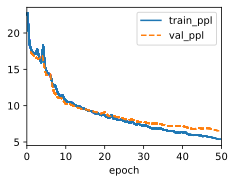

In [22]:
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=64)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [28]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has inttong the the the'

In [27]:
model.predict('laser ', 20, data.vocab, d2l.try_gpu())

'laser the the the the the '

In [26]:
model.predict('victory', 20, data.vocab, d2l.try_gpu())

'victory the the the the the'

Doubling the hidden layers to 64 did not seem to have much of an impact on perplexity or training time, however the output seems to be very skewed towards the and i'm not entirely sure what 'inttong'

In [12]:
## Problem 1-2 LSTM

class LSTMScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
    if H_C is None:
        # Initial state with shape: (batch_size, num_hiddens)
        H = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
        C = torch.zeros((inputs.shape[1], self.num_hiddens),
                      device=inputs.device)
    else:
        H, C = H_C
    outputs = []
    for X in inputs:
        I = torch.sigmoid(torch.matmul(X, self.W_xi) +
                        torch.matmul(H, self.W_hi) + self.b_i)
        F = torch.sigmoid(torch.matmul(X, self.W_xf) +
                        torch.matmul(H, self.W_hf) + self.b_f)
        O = torch.sigmoid(torch.matmul(X, self.W_xo) +
                        torch.matmul(H, self.W_ho) + self.b_o)
        C_tilde = torch.tanh(torch.matmul(X, self.W_xc) +
                           torch.matmul(H, self.W_hc) + self.b_c)
        C = F * C + I * C_tilde
        H = O * torch.tanh(C)
        outputs.append(H)
    return outputs, (H, C)

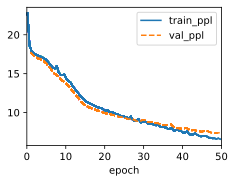

In [37]:
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=128)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [38]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has of the and the and '

In [39]:
model.predict('laser ', 20, data.vocab, d2l.try_gpu())

'laser and the and the and '

In [40]:
model.predict('victory', 20, data.vocab, d2l.try_gpu())

'victory and the and the and'

The LSTM with 128 hidden layers seemed to have negligble impact on training time or perplexity, but seems to have tried to make more coherent sentences

In [ ]:
## Problem 1-3 Model Comparison

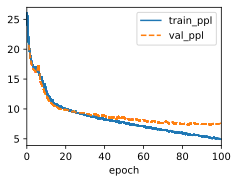

In [60]:
rnn = d2l.RNNScratch(num_inputs=len(data.vocab), num_hiddens=128)
model = d2l.RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [48]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has of the the the the '

In [49]:
model.predict('laser ', 20, data.vocab, d2l.try_gpu())

'laser and the the the the '

In [50]:
model.predict('victory', 20, data.vocab, d2l.try_gpu())

'victory the the the the the'

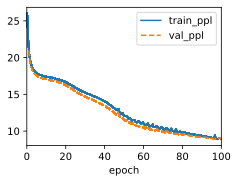

In [61]:
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=128)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [62]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the the the the the'

In [63]:
model.predict('laser ', 20, data.vocab, d2l.try_gpu())

'laser ant ant ant ant ant '

In [64]:
model.predict('victory', 20, data.vocab, d2l.try_gpu())

'victory the the the the the'

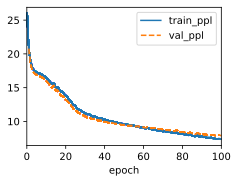

In [65]:
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=128)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [66]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has a dimention the the'

In [67]:
model.predict('laser ', 20, data.vocab, d2l.try_gpu())

'laser and the the the the '

In [70]:
model.predict('victory', 20, data.vocab, d2l.try_gpu())

'victory and the the the the'

The fastest training model was the traditional rnn, however the best performing was GRU, which had the lowest perplexity and seemed to be the most likely to make a complete sentence.

In [ ]:
##_________________________________________##
## Problem 2
##_________________________________________##

In [77]:
# Problem 2-1 and 2-2 Deep Fried LSTM (tm)
class StackedRNNScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(*[d2l.RNNScratch(
            num_inputs if i==0 else num_hiddens, num_hiddens, sigma)
                                    for i in range(num_layers)])
@d2l.add_to_class(StackedRNNScratch)
def forward(self, inputs, Hs=None):
    outputs = inputs
    if Hs is None: Hs = [None] * self.num_layers
    for i in range(self.num_layers):
        outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
        outputs = torch.stack(outputs, 0)
    return outputs, Hs

class LSTM(d2l.RNN):  #@save
    """The multi-layer GRU model."""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens, num_layers,
                          dropout=dropout)

class GRU(d2l.RNN):  #@save
    """The multi-layer GRU model."""
    def __init__(self, num_inputs, num_hiddens, num_layers, dropout=0):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers,
                          dropout=dropout)

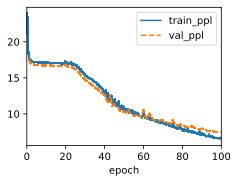

In [73]:
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

In [74]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has in the the the the '

In [75]:
model.predict('laser ', 20, data.vocab, d2l.try_gpu())

'laser the the the the the '

In [76]:
model.predict('victory', 20, data.vocab, d2l.try_gpu())

'victory the the the the the'

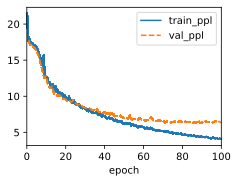

In [78]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32, num_layers=2)
model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

In [79]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the time traveller '

In [80]:
model.predict('laser ', 20, data.vocab, d2l.try_gpu())

'laser man a move and the t'

In [81]:
model.predict('victory', 20, data.vocab, d2l.try_gpu())

'victory can a man a move an'

The LSTM Model had slightly higher perplexity, equivalent training time and was much less likely to produce a coherent sentence

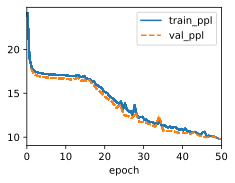

In [133]:
# Problem 2-3
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=16, num_layers=2)
model = d2l.RNNLM(lstm, vocab_size=len(data.vocab), lr=2)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [134]:
model.predict('it has', 20, data.vocab, d2l.try_gpu())

'it has the the the the the'

In [135]:
model.predict('laser ', 20, data.vocab, d2l.try_gpu())

'laser the the the the the '

In [136]:
model.predict('victory', 20, data.vocab, d2l.try_gpu())

'victory the the the the the'

Having more than 2 LSTM Layers made the model not train at all, and the less hidden layers the quicker it trains and the less perplexity it has, which also means somewhat more clear sentences